In [40]:
import numpy as np
import time
import pickle
import matplotlib.pyplot as plt
from generative_model_utils import event_dict_to_aggregated_adjacency, event_dict_to_adjacency
from spectral_clustering import *
from MultiBlockFit_Hessian import fit_kernel_sum_model, fit_n_r_br_gr_fixed_beta_model, print_paramters_kernel


In [41]:
n_classes = 4
timestamp_max = 1000
kernel = "single"
# kernel = "sum"
beta = 1
betas = np.array([0.02, 0.2, 2, 20])


def create_incident_event_dict(dnx_pickle_file_name, timestamp_max=1000):
    incident_dnx = pickle.load(open(dnx_pickle_file_name, 'rb'))
    event_dict = {}

    timestamp_first = incident_dnx.edges()[0][2]
    timestamp_last = incident_dnx.edges()[-1][2]
    duration = timestamp_last - timestamp_first

    if timestamp_max is None:
        timestamp_max = timestamp_last - timestamp_first

    node_set = set(incident_dnx.nodes())
    node_id_map, id_node_map = get_node_id_maps(node_set)

    for edge in incident_dnx.edges():
        sender_id = node_id_map[edge[0]]
        receiver_id = node_id_map[edge[1]]
        timestamp = (edge[2] - timestamp_first) / duration * timestamp_max
        if timestamp < 0:
            print(edge)

        if (sender_id, receiver_id) not in event_dict:
            event_dict[(sender_id, receiver_id)] = []

        event_dict[(sender_id, receiver_id)].append(timestamp)

    return event_dict, len(incident_dnx.nodes()), duration, id_node_map


def get_node_id_maps(node_set):
    nodes = list(node_set)
    nodes.sort()

    node_id_map = {}
    id_node_map = {}
    for i, n in enumerate(nodes):
        node_id_map[n] = i
        id_node_map[i] = n

    return node_id_map, id_node_map

In [42]:
dnx_pickle_file_name = 'incident_impulse.pckl'
events_dict, n_nodes, duration, id_node_map = create_incident_event_dict(
    dnx_pickle_file_name, timestamp_max)

agg_adj = event_dict_to_aggregated_adjacency(n_nodes, events_dict)
unweight_adj = event_dict_to_adjacency(n_nodes, events_dict)
node_membership = spectral_cluster(agg_adj,n_classes,n_kmeans_init=100)
                              

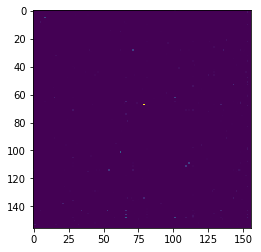

In [58]:
plt.imshow(agg_adj)

In [43]:
beta_bp = np.ones((n_classes, n_classes)) * beta
params_est,sd, ll, n_events = fit_n_r_br_gr_fixed_beta_model(
    events_dict, node_membership, n_classes, timestamp_max, beta_bp)

/Users/Lynfi/multivariate-block-hawkes-model/MultivariateBlockHawkes/MultiBlockFit_Hessian.py:470: RuntimeWarning: invalid value encountered in sqrt
  I = np.sqrt(np.diagonal(np.linalg.pinv(-H_est)))


In [44]:
print(np.histogram(node_membership, bins=n_classes))
for i in range(n_classes):
    print(f"Class {i}")
    nodes_in_class_i = np.where(node_membership == i)[0]
    for id in nodes_in_class_i:
        print(id_node_map[id], end=' ')
    print()

(array([36, 46, 49, 25]), array([0.  , 0.75, 1.5 , 2.25, 3.  ]))
Class 0
ARG ARM AUS AZE BOT BUI CDI CHL COL CON COS CYP DJI EST FIN GAM GNB GRC GRG HON IRE IRQ KOS LAT LIB MLD MOR PER SAL SYR TOG UKR YEM YUG ZAM ZIM 
Class 1
ALB ANG AUL BAH BEL BOS BUL CAN CEN CRO CZR DEN ERI FRN GHA GMY HUN ICE IRN ITA JOR KUW LIT LUX MAC MNG NAM NOR NTH OMA POL POR QAT ROM RUM SAU SEN SLO SLV SPN SWD TAZ TUN TUR UAE UKG 
Class 2
AFG ALG BEN BHU CAM CAO CHA DOM DRV EGY ETH GUI GUY HAI IND INS ISR JPN KEN LBR LEB MAA MAL MLI MYA MZM NIG NIR PAN PHI PNG PRK ROK RWA SIE SIN SOL SOM SSD SUD SUR SWZ TAW THI TRI UGA USA VEN VTM 
Class 3
BLR BLZ BNG BRA CHN CUB DRC ECU EQG GUA JAM KYR KZK LES NEP NIC PAK PAL RUS SAF SRI SWA TAJ TKM UZB 


Text(0.5, 1.0, 'alpha_gr')

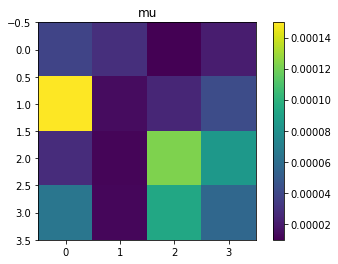

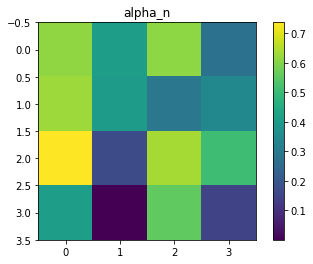

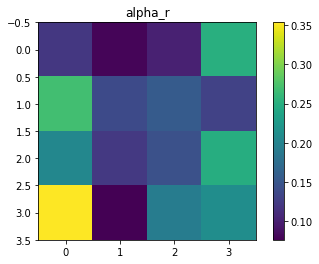

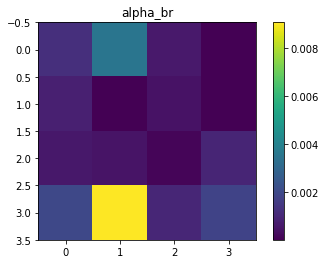

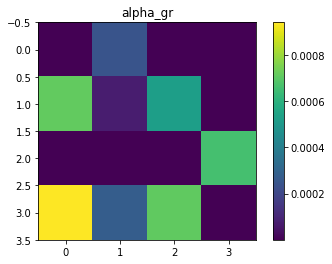

In [45]:
beta_bp = np.ones((n_classes, n_classes)) * beta
params_est,sd, ll, n_events = fit_n_r_br_gr_fixed_beta_model(
    events_dict, node_membership, n_classes, timestamp_max, beta_bp)
end_fit_time = time.time()
#print_paramters_6(params_est)

#%% Plot parameters
plt.figure()
plt.imshow(params_est[0])
plt.colorbar()
plt.title("mu")

plt.figure()
plt.imshow(params_est[1])
plt.colorbar()
plt.title("alpha_n")

plt.figure()
plt.imshow(params_est[2])
plt.colorbar()
plt.title("alpha_r")

plt.figure()
plt.imshow(params_est[3])
plt.colorbar()
plt.title("alpha_br")

plt.figure()
plt.imshow(params_est[4])
plt.colorbar()
plt.title("alpha_gr")

In [ ]:
f = plt.figure()
plt.imshow(params_est[1])
plt.colorbar()
plt.title("alpha_n")
f.set_figheight(4)
f.set_figwidth(4)
f.savefig('MID_gr_ht.pdf')

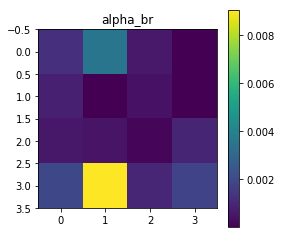

In [55]:
f = plt.figure()
# plt.figure()
plt.imshow(params_est[3])
plt.colorbar()
plt.title("alpha_br")
f.set_figheight(4)
f.set_figwidth(4)
f.savefig('MID_br_ht.pdf')

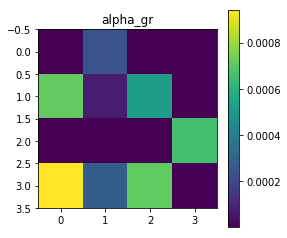

In [56]:
f = plt.figure()
plt.imshow(params_est[4])
plt.colorbar()
plt.title("alpha_gr")
f.set_figheight(4)
f.set_figwidth(4)
f.savefig('MID_gr_ht.pdf')

In [46]:
sd

(array([[5.78507367e-06, 4.45916986e-06, 2.41047352e-06, 4.96202303e-06],
        [1.00212885e-05, 2.72301903e-06, 3.35526614e-06, 6.14000952e-06],
        [4.06133224e-06, 2.36082498e-06, 7.67675331e-06, 8.92105883e-06],
        [8.84656118e-06, 3.25945835e-06, 9.35489028e-06, 9.94712080e-06]]),
 array([[0.05452829, 0.04032386, 0.07204914, 0.06818521],
        [0.02606447, 0.08174224, 0.05727821, 0.06805133],
        [0.05080742, 0.06537766, 0.02238296, 0.03244902],
        [0.05418839, 0.09754406, 0.03291731, 0.05625053]]),
 array([[0.02561453, 0.01039222, 0.02065722, 0.04223525],
        [0.0343203 , 0.05128211, 0.06383581, 0.06938619],
        [0.04953183, 0.03825374, 0.01155926, 0.02265578],
        [0.07824695, 0.03099206, 0.02262804, 0.0639815 ]]),
 array([[4.16154950e-04, 5.44885117e-04, 3.66692750e-04,            nan],
        [1.99860714e-04, 1.03824076e-02, 3.27269762e-04, 0.00000000e+00],
        [2.63857232e-04, 1.96194836e+00, 7.67401448e-05, 3.26637592e-04],
        [6.8

In [47]:
params_est

(array([[3.85515558e-05, 2.86739876e-05, 9.65096027e-06, 2.11341300e-05],
        [1.49812165e-04, 1.44089635e-05, 2.46572684e-05, 4.20028816e-05],
        [2.76198645e-05, 1.14911745e-05, 1.22921089e-04, 8.44814718e-05],
        [6.45634632e-05, 1.21941224e-05, 9.35013799e-05, 5.66460283e-05]]),
 array([[6.14979738e-01, 4.10470948e-01, 6.11915929e-01, 2.78464008e-01],
        [6.28868181e-01, 4.06099049e-01, 2.91998361e-01, 3.44757849e-01],
        [7.37748587e-01, 1.68665342e-01, 6.37579474e-01, 5.08879325e-01],
        [4.10947599e-01, 1.00000000e-07, 5.57504508e-01, 1.50207622e-01]]),
 array([[0.12116538, 0.07948131, 0.10164239, 0.25153365],
        [0.26998061, 0.13870624, 0.15548482, 0.13046942],
        [0.20490002, 0.12235078, 0.14484845, 0.24932972],
        [0.35377085, 0.07589928, 0.19254231, 0.21192063]]),
 array([[1.23680610e-03, 3.53712418e-03, 6.18148603e-04, 1.00000000e-07],
        [8.03748812e-04, 1.00000000e-07, 4.37222265e-04, 1.00000000e-07],
        [5.86995743e-0

In [48]:
from scipy.stats import norm
p = np.zeros((5,n_classes,n_classes))

In [49]:
for i in range(5):
    for j in range(n_classes):
        for k in range(n_classes):
            if (params_est[i][j,k] < 1.1e-7): #estimation is 0 in face
                p[i,j,k]=0.5
            elif sd[i][j, k] == 0:      #sd is 0, avoid divided by 0
                if p[i,j,k] < 1.1e-7:
                    p[i,j,k] = 0.5
                else:
                    p[i,j,k] = 0
            else:
                p[i,j,k] = 1 - norm.cdf(params_est[i][j,k] / sd[i][j, k])

In [50]:
p

array([[[1.33264511e-11, 6.36585229e-11, 3.11716532e-05, 1.02590877e-05],
        [0.00000000e+00, 6.06454055e-08, 1.00031095e-13, 3.93629573e-12],
        [5.20594678e-12, 5.65265090e-07, 0.00000000e+00, 0.00000000e+00],
        [1.45883305e-13, 9.15900956e-05, 0.00000000e+00, 6.17887119e-09]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.21396372e-05],
        [0.00000000e+00, 3.38158266e-07, 1.71725020e-07, 2.02977437e-07],
        [0.00000000e+00, 4.94199078e-03, 0.00000000e+00, 0.00000000e+00],
        [1.67643677e-14, 5.00000000e-01, 0.00000000e+00, 3.78880982e-03]],

       [[1.12073172e-06, 1.02140518e-14, 4.31771126e-07, 1.29608280e-09],
        [1.77635684e-15, 3.41760166e-03, 7.43151976e-03, 3.00310719e-02],
        [1.76141975e-05, 6.90960125e-04, 0.00000000e+00, 0.00000000e+00],
        [3.07436624e-06, 7.16284833e-03, 0.00000000e+00, 4.62797994e-04]],

       [[1.47940761e-03, 4.24916768e-11, 4.59229530e-02, 5.00000000e-01],
        [2.89088570e-05, 5.00000

In [51]:
p<0.05

array([[[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]],

       [[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True, False,  True,  True]],

       [[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]],

       [[ True,  True,  True, False],
        [ True, False, False, False],
        [ True, False, False,  True],
        [ True,  True,  True, False]],

       [[False,  True, False, False],
        [False, False, False, False],
        [False, False, False,  True],
        [False, False,  True, False]]])

In [52]:
params_est[:5]

(array([[3.85515558e-05, 2.86739876e-05, 9.65096027e-06, 2.11341300e-05],
        [1.49812165e-04, 1.44089635e-05, 2.46572684e-05, 4.20028816e-05],
        [2.76198645e-05, 1.14911745e-05, 1.22921089e-04, 8.44814718e-05],
        [6.45634632e-05, 1.21941224e-05, 9.35013799e-05, 5.66460283e-05]]),
 array([[6.14979738e-01, 4.10470948e-01, 6.11915929e-01, 2.78464008e-01],
        [6.28868181e-01, 4.06099049e-01, 2.91998361e-01, 3.44757849e-01],
        [7.37748587e-01, 1.68665342e-01, 6.37579474e-01, 5.08879325e-01],
        [4.10947599e-01, 1.00000000e-07, 5.57504508e-01, 1.50207622e-01]]),
 array([[0.12116538, 0.07948131, 0.10164239, 0.25153365],
        [0.26998061, 0.13870624, 0.15548482, 0.13046942],
        [0.20490002, 0.12235078, 0.14484845, 0.24932972],
        [0.35377085, 0.07589928, 0.19254231, 0.21192063]]),
 array([[1.23680610e-03, 3.53712418e-03, 6.18148603e-04, 1.00000000e-07],
        [8.03748812e-04, 1.00000000e-07, 4.37222265e-04, 1.00000000e-07],
        [5.86995743e-0